In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pymongo import MongoClient
import matplotlib
import squarify

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_DataFrames():
    'Returns 4 DataFrames i.e. Actor, Movie, Titles and Ratings'
    
    actor_df = pd.read_csv('./datasets/name-basics.tsv', sep='\t', na_values='\\N')
    movie_df = pd.read_csv('./datasets/title-basics.tsv', sep='\t', na_values='\\N')
    title_df = pd.read_csv('./datasets/title-principals.tsv', sep='\t', na_values='\\N')
    ratings_df = pd.read_csv('./datasets/title-ratings.tsv', sep='\t', na_values='\\N')
    
    return actor_df, movie_df, title_df, ratings_df

In [3]:
def store_DataFrames(db, df):
    'Stores the DataFrame df as No-SQL in MongoDB Database db'
    
    db.coll.insert_many(df.to_dict('records'))

In [4]:
def load_DataFrames(db, coll):
    'Retrieves a Pandas DataFrame df from MongoDB Database db'
    
    collection = db.coll
    return pd.DataFrame(list(collection.find()))

In [5]:
def query_movie(movie_name, movie_df, ratings_df):
    'Queries the Movie database and returns genres and rating of the current movie and movies similar to it'
    
    if sum(movie_df.originalTitle.isin([movie_name])) < 1:
        print('Invalid Movie Name')
        return
    
    merged_df = pd.merge(movie_df, ratings_df, on='tconst')
    out_df = merged_df[(merged_df.originalTitle.isin([movie_name])) & (merged_df.titleType.isin(['movie']))]
    genres = out_df['genres'].iloc[0]
    year = out_df['startYear'].iloc[0]
    rating = out_df['averageRating'].iloc[0]
    
    print(movie_name, 'is a', genres, 'movie has a rating of', str(rating), 'and here are a bunch of similar movies around the same time.')
    
    genres = genres.split(',')
    
    out_df = merged_df[(merged_df.startYear == year) & (merged_df.averageRating > rating-0.5) & (merged_df.averageRating < rating+0.5) & (merged_df.titleType.isin(['movie']))]
    
    concat_df = []
    for genre in genres:
        concat_df.append(out_df[out_df.genres.astype(str).str.contains(genre)])
        
    display(pd.concat(concat_df).drop_duplicates().reset_index(drop=True))

In [6]:
def query_actor(actor_name, actor_df, movie_df, title_df, ratings_df):
    'Queries the Actor Name and returns a bunch of statistics about the Actor over the years'
    
    if sum(actor_df.primaryName.isin([actor_name])) < 1:
        print('Invalid Actor Name')
        return
    nconst = actor_df[(actor_df.primaryName.isin([actor_name]))].nconst.iloc[0]
    tconst_list = title_df[(title_df.nconst == nconst) & title_df.category.isin(['actor'])].tconst.tolist()
    out_df = movie_df[movie_df.tconst.isin(tconst_list) & movie_df.titleType.isin(['movie'])]
    merged_df = pd.merge(out_df, ratings_df, on='tconst')
    
    print('The list of all the movies', actor_name, 'has worked in over the years.')
    display(merged_df)
    
    print('\nThe Various Genres', actor_name, 'has worked in and number of movies in each.')
    genres = merged_df.genres
    genre_arr = np.array([genre for each in genres for genre in each.split(',')])
    unique, counts = np.unique(genre_arr, return_counts=True)

    norm = matplotlib.colors.Normalize(vmin=min(counts), vmax=max(counts))
    colors = [matplotlib.cm.BuGn(norm(value)) for value in counts]

    fig = plt.gcf()
    ax = fig.add_subplot()
    fig.set_size_inches(16, 4.5)

    squarify.plot(label=unique,sizes=counts, value=counts, color = colors, alpha=.9)
    plt.title("Genres",fontsize=16,fontweight="bold")

    plt.axis('off')
    plt.show()
    
    merged_df2 = pd.merge(movie_df, ratings_df, on='tconst')
    grouped = merged_df.groupby(merged_df.startYear)
    
    print('\nSimilar movies over the years sorted by Ratings')
    for keys in grouped.genres.groups.keys():
        df_list = []
        for genre in grouped.genres.get_group(keys):
            df_list.append(merged_df2[((merged_df2.startYear == keys) & (merged_df2.genres.isin([genre])) & (merged_df2.titleType.isin(['movie'])))])
        final = pd.concat(df_list)
        print(keys, grouped.genres.get_group(keys))
        display(final.sort_values('averageRating', ascending=False).head(3))
        
    print('\nGraph showing the number of Movies', actor_name, 'has worked over the years.')
    years = merged_df.startYear.value_counts()

    plt.figure(figsize=(16,4))
    plt.bar(years.index, years.values)
    plt.show()
    
    print('\nThe overall IMDB rating of', actor_name, 'is', round(merged_df.averageRating.mean(), 2))
    
    print('\nGraph showing average rating for', actor_name, 'over the years.')
    ratings = merged_df.groupby('startYear').averageRating.mean()

    plt.figure(figsize=(16,4))
    plt.bar(ratings.index, ratings.values)
    plt.show()

Query the Database, for Movie input 1, for Actor input 2 to exit input 0: 3
Please enter a valid input
Query the Database, for Movie input 1, for Actor input 2 to exit input 0: 1
Input a Movie Name: The dark knight
Invalid Movie Name
Query the Database, for Movie input 1, for Actor input 2 to exit input 0: 1
Input a Movie Name: The Dark Knight
The Dark Knight is a Action,Crime,Drama movie has a rating of 9.0 and here are a bunch of similar movies around the same time.


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0468569,movie,The Dark Knight,The Dark Knight,0,2008.0,NaN,152,"Action,Crime,Drama",9.0,2034554
1,tt1152758,movie,Dear Zachary: A Letter to a Son About His Father,Dear Zachary: A Letter to a Son About His Father,0,2008.0,NaN,95,"Biography,Crime,Documentary",8.6,29002
2,tt1188756,movie,"Turk Diamond, P.I.","Turk Diamond, P.I.",0,2008.0,NaN,NaN,"Crime,Mystery",8.8,11
3,tt1334056,movie,Sex and Justice,Sex and Justice,0,2008.0,NaN,45,"Crime,Drama,Mystery",8.6,30
4,tt1339117,movie,Lost Causes,Lost Causes,0,2008.0,NaN,92,Crime,8.9,7
5,tt2122378,movie,L'Infame e suo fratello,L'Infame e suo fratello,0,2008.0,NaN,92,"Crime,Documentary",9.0,5
6,tt2165739,movie,"Easy come, easy go","Easy come, easy go",0,2008.0,NaN,94,Crime,9.0,5
7,tt0815229,movie,We Pedal Uphill,We Pedal Uphill,0,2008.0,NaN,111,"Comedy,Drama,History",9.0,19
8,tt1019450,movie,Road to Pecumsecah,Road to Pecumsecah,0,2008.0,NaN,NaN,"Comedy,Drama",8.7,21
9,tt1043720,movie,Chance Encounter,Chance Encounter,0,2008.0,NaN,NaN,Drama,8.7,7


Query the Database, for Movie input 1, for Actor input 2 to exit input 0: 2
Input Actor Name: Leonardo DiCaprio
The list of all the movies Leonardo DiCaprio has worked in over the years.


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0108330,movie,This Boy's Life,This Boy's Life,0,1993.0,NaN,115,"Biography,Drama",7.3,42173
1,tt0108550,movie,What's Eating Gilbert Grape,What's Eating Gilbert Grape,0,1993.0,NaN,118,Drama,7.8,195898
2,tt0112461,movie,The Basketball Diaries,The Basketball Diaries,0,1995.0,NaN,102,"Biography,Crime,Drama",7.3,93293
3,tt0114214,movie,The Quick and the Dead,The Quick and the Dead,0,1995.0,NaN,107,"Action,Romance,Thriller",6.4,78126
4,tt0114702,movie,Total Eclipse,Total Eclipse,0,1995.0,NaN,111,"Biography,Drama,Romance",6.6,12204
5,tt0116999,movie,Marvin's Room,Marvin's Room,0,1996.0,NaN,98,Drama,6.7,23342
6,tt0117509,movie,Romeo + Juliet,Romeo + Juliet,0,1996.0,NaN,120,"Drama,Romance",6.8,193597
7,tt0119004,movie,Don's Plum,Don's Plum,0,2001.0,NaN,89,"Comedy,Drama",5.9,3723
8,tt0120338,movie,Titanic,Titanic,0,1997.0,NaN,194,"Drama,Romance",7.8,944395
9,tt0120533,movie,Celebrity,Celebrity,0,1998.0,NaN,113,"Comedy,Drama",6.3,22700



The Various Genres Leonardo DiCaprio has worked in and number of movies in each.


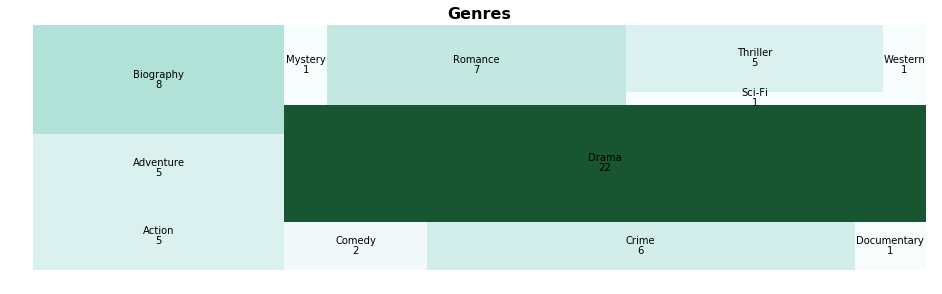


Similar movies over the years sorted by Ratings
1993.0 0    Biography,Drama
1              Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
195921,tt0364522,movie,Misa de cuerpo presente,Misa de cuerpo presente,0,1993.0,NaN,90,Drama,10.0,5
226841,tt0438430,movie,Silang mga sisiw sa lansangan,Silang mga sisiw sa lansangan,0,1993.0,NaN,NaN,Drama,9.6,25
726698,tt4127096,movie,Manvi Ni Bhavai,Manvi Ni Bhavai,0,1993.0,NaN,180,Drama,9.5,13


1995.0 2      Biography,Crime,Drama
3    Action,Romance,Thriller
4    Biography,Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
80982,tt0112461,movie,The Basketball Diaries,The Basketball Diaries,0,1995.0,NaN,102,"Biography,Crime,Drama",7.3,93293
81127,tt0112637,movie,Carrington,Carrington,0,1995.0,NaN,121,"Biography,Drama,Romance",6.9,4808
82779,tt0114702,movie,Total Eclipse,Total Eclipse,0,1995.0,NaN,111,"Biography,Drama,Romance",6.6,12204


1996.0 5            Drama
6    Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
772790,tt5093808,movie,Gothalo,Gothalo,0,1996.0,NaN,138,"Drama,Romance",9.4,7
357192,tt0774044,movie,Of Earth and Sky,Of Earth and Sky,0,1996.0,NaN,56,Drama,9.1,39
90490,tt0125465,movie,Posledniye kanikuly,Posledniye kanikuly,0,1996.0,NaN,NaN,Drama,8.9,14


1997.0 8    Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
790896,tt5471570,movie,Amrutha Varshini,Amrutha Varshini,0,1997.0,NaN,147,"Drama,Romance",9.0,99
91175,tt0126622,movie,Across the Lake,Preku ezeroto,0,1997.0,NaN,102,"Drama,Romance",8.6,368
86451,tt0119217,movie,Good Will Hunting,Good Will Hunting,0,1997.0,NaN,126,"Drama,Romance",8.3,756365


1998.0 9               Comedy,Drama
10    Action,Adventure,Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
122715,tt0192991,movie,Avenged,Avenged,0,1998.0,NaN,107,"Comedy,Drama",8.3,36
152704,tt0263438,movie,Everything's Gonna Be Great,Her Sey Çok Güzel Olacak,0,1998.0,NaN,107,"Comedy,Drama",8.2,18033
84442,tt0116753,movie,Die kaukasische Nacht,Die kaukasische Nacht,0,1998.0,NaN,108,"Comedy,Drama",8.1,44


2000.0 11    Adventure,Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
107785,tt0162222,movie,Cast Away,Cast Away,0,2000.0,NaN,143,"Adventure,Drama,Romance",7.8,468091
142274,tt0239441,movie,Gran Paradiso,Gran Paradiso,0,2000.0,NaN,102,"Adventure,Drama,Romance",6.7,225
108562,tt0163978,movie,The Beach,The Beach,0,2000.0,NaN,119,"Adventure,Drama,Romance",6.6,206450


2001.0 7    Comedy,Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
198295,tt0369688,movie,Make Pretend,Make Pretend,0,2001.0,NaN,105,"Comedy,Drama",8.3,12
196213,tt0365240,movie,For Me,For Me,0,2001.0,NaN,60,"Comedy,Drama",8.3,6
135872,tt0222849,movie,Breathing Hard,Breathing Hard,0,2001.0,NaN,93,"Comedy,Drama",8.1,24


2002.0 12              Crime,Drama
13    Biography,Crime,Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
178034,tt0317248,movie,City of God,Cidade de Deus,0,2002.0,NaN,130,"Crime,Drama",8.6,636687
175174,tt0310953,movie,Urban Playground,Urban Playground,0,2002.0,NaN,120,"Crime,Drama",8.4,17
153156,tt0264464,movie,Catch Me If You Can,Catch Me If You Can,0,2002.0,NaN,141,"Biography,Crime,Drama",8.1,707198


2004.0 14    Biography,Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
198302,tt0369702,movie,The Sea Inside,Mar adentro,0,2004.0,NaN,125,"Biography,Drama",8.0,72445
186267,tt0338751,movie,The Aviator,The Aviator,0,2004.0,NaN,170,"Biography,Drama",7.5,305169
197097,tt0367188,movie,Modigliani,Modigliani,0,2004.0,NaN,128,"Biography,Drama",7.4,9964


2006.0 15        Crime,Drama,Thriller
16    Adventure,Drama,Thriller
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
214625,tt0407887,movie,The Departed,The Departed,0,2006.0,NaN,151,"Crime,Drama,Thriller",8.5,1062112
389059,tt0880490,movie,Sucker Lake Park,Sucker Lake Park,0,2006.0,NaN,150,"Crime,Drama,Thriller",8.2,13
231384,tt0450259,movie,Blood Diamond,Blood Diamond,0,2006.0,NaN,143,"Adventure,Drama,Thriller",8.0,459202


2008.0 17    Action,Drama,Thriller
18            Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
375971,tt0835372,movie,Reservations,Reservations,0,2008.0,NaN,NaN,"Drama,Romance",8.3,41
437299,tt1120944,movie,Radio Cape Cod,Radio Cape Cod,0,2008.0,NaN,NaN,"Drama,Romance",8.2,22
572093,tt1922545,movie,Anjathe,Anjathe,0,2008.0,NaN,185,"Action,Drama,Thriller",8.1,1609


2010.0 20           Mystery,Thriller
22    Action,Adventure,Sci-Fi
23                Documentary
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
859127,tt7031058,movie,Soberano: Seis Vezes São Paulo,Soberano: Seis Vezes São Paulo,0,2010.0,NaN,90,Documentary,9.5,10
636881,tt2498292,movie,Under a Jarvis Moon,Under a Jarvis Moon,0,2010.0,NaN,56,Documentary,9.5,6
463132,tt1262932,movie,Moonshine to the Finish Line: An Unofficial Hi...,Moonshine to the Finish Line: An Unofficial Hi...,0,2010.0,NaN,NaN,Documentary,9.4,5


2011.0 24    Biography,Crime,Drama
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
520415,tt1582244,movie,Guilty,Présumé coupable,0,2011.0,NaN,102,"Biography,Crime,Drama",7.3,1597
545777,tt1734110,movie,No One Killed Jessica,No One Killed Jessica,0,2011.0,NaN,136,"Biography,Crime,Drama",7.2,9911
492597,tt1416801,movie,Kill the Irishman,Kill the Irishman,0,2011.0,NaN,106,"Biography,Crime,Drama",7.1,41166


2012.0 26    Drama,Western
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
564050,tt1853728,movie,Django Unchained,Django Unchained,0,2012.0,NaN,165,"Drama,Western",8.4,1193551
658208,tt2879728,movie,Sin sangre nunca,Sin sangre nunca,0,2012.0,NaN,85,"Drama,Western",7.4,5
596516,tt2123169,movie,Cooper,Cooper,0,2012.0,NaN,NaN,"Drama,Western",6.1,19


2013.0 19    Biography,Crime,Drama
21            Drama,Romance
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
884036,tt7801794,movie,Mallela Theeramlo Sirimalle Puvvu,Mallela Theeramlo Sirimalle Puvvu,0,2013.0,NaN,NaN,"Drama,Romance",8.8,11
670281,tt3103784,movie,Shiren to Ragi,Shiren to Ragi,0,2013.0,NaN,171,"Drama,Romance",8.4,5
675982,tt3202972,movie,Gombegala Love,Gombegala Love,0,2013.0,NaN,134,"Drama,Romance",8.3,33


2015.0 25    Action,Adventure,Biography
Name: genres, dtype: object


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
533724,tt1663202,movie,The Revenant,The Revenant,0,2015.0,NaN,156,"Action,Adventure,Biography",8.0,609867
697154,tt3557446,movie,Frackman,Frackman,0,2015.0,NaN,90,"Action,Adventure,Biography",8.0,53
649917,tt2719848,movie,Everest,Everest,0,2015.0,NaN,121,"Action,Adventure,Biography",7.1,179482



Graph showing the number of Movies Leonardo DiCaprio has worked over the years.


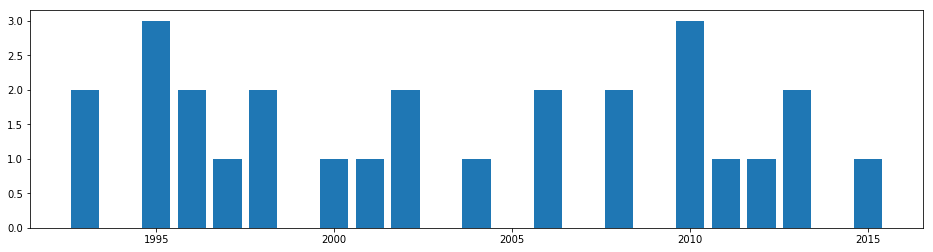


The overall IMDB rating of Leonardo DiCaprio is 7.38

Graph showing average rating for Leonardo DiCaprio over the years.


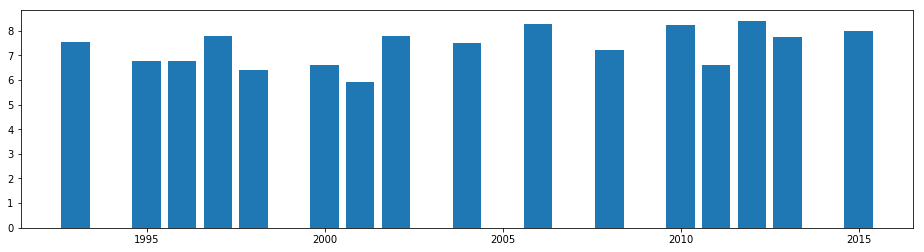

Query the Database, for Movie input 1, for Actor input 2 to exit input 0: 0


In [7]:
if __name__ == '__main__':
    'Asks for movie or actor name and queries the database accordingly'
    
    keep_going = True
    actor_df, movie_df, title_df, ratings_df = read_DataFrames()
    
#     client = MongoClient()
#     db = client.database_name
#     store_DataFrames(db, df)
#     df = load_DataFrames(db, coll)
    
    while keep_going:
        choice = int(input('Query the Database, for Movie input 1, for Actor input 2 to exit input 0: '))
        if choice == 0:
            keep_going = False
        elif choice == 1:
            movie_name = input('Input a Movie Name: ')
            query_movie(movie_name, movie_df, ratings_df)
        elif choice == 2:
            actor_name = input('Input Actor Name: ')
            query_actor(actor_name, actor_df, movie_df, title_df, ratings_df)
        else:
            print('Please enter a valid input')            